# 시계열 데이터에 RNN 모델 적용하기
---

## 1.주식 데이터를 이용한 가격 예측

---

### 1.1 라이브러리 설치 및 로드


**FinanceDataReader 상세 설명**

FinanceDataReader는 한국 주식 가격, 미국주식 가격, 지수, 환율, 암호화폐 가격, 종목 리스팅 등 금융 데이터 수집 라이브러리입니다.

기존에 사용되던 pandas-datareader 는 잘 구성된 시계열 데이터 수집 라이브러리로 사용이 간편하고 다양한 시계열 데이터를 수집할 수 있다는 장점이 있습니다. 하지만, 거래소별(KRX, NASDAQ, NYSE 등) 전체 종목 코드(ticker symbol)를 가져오는 기능이 없으며, 야후 파이낸스가 더 이상지원되지 않고(deprecated), 구글 파이낸스는 UNSTABLE_WARNING + RemoteDataError 가 있습니다.

FinanceDataReader는 pandas-datareader 를 대체하기 보다 보완하기 위한 목적으로 만들어졌으며 주요한 기능은 다음과 같습니다.

- 거래소별 전체 종목코드: KRX (KOSPI, KODAQ, KONEX), NASDAQ, NYSE, AMEX, S&P 500 가격 데이터
- 해외주식 가격 데이터: AAPL(애플), AMZN(아마존), GOOG(구글) 등
- 국내주식 가격 데이터: 005920(삼성전자), 091990(셀트리온헬스케어) 등
- 각종 지수: KS11(코스피지수), KQ11(코스닥지수), DJI(다우지수), IXIC(나스닥 지수), US500(S&P 5000)
- 환율 데이터: USD/KRX (원달러 환율), USD/EUR(달러당 유로화 환율), CNY/KRW: 위엔화 원화 환율
- 암호화폐 가격: BTC/USD (비트코인 달러 가격, Bitfinex), BTC/KRW (비트코인 원화 가격, 빗썸)

라이브러리를 설치합니다.

In [2]:
# !pip install -U finance-datareader

In [5]:
# !pip install tensorflow

라이브러리를 로드합니다.

- **tensorflow**: 딥러닝 학습을 위한 Tensor을 다루기 위한 라이브러리
- **tensorflow.kears**: 사용자 친화적인 keras의 API를 사용하여 tensorflow를 다루기 위한 라이브러리

In [6]:
import FinanceDataReader as fdr
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow.keras import Sequential, layers, callbacks, backend

### 1.2 데이터 로드 및 시각화

삼성전자 주식 데이터를 가져와 `df`에 저장합니다.

In [7]:
df = fdr.DataReader("005930", start = '1999').reset_index()  # "005930" 삼성전자의 코드
df

,Date,Open,High,Low,Close,Volume,Change
0,1999-04-02,1878,1937,1864,1878,272639,NaN
1,1999-04-06,1878,1927,1855,1859,508559,-0.010117
2,1999-04-07,1858,1954,1843,1918,1160590,0.031737
3,1999-04-08,1907,1935,1878,1902,462018,-0.008342
4,1999-04-09,1933,1937,1866,1933,531670,0.016299
...,...,...,...,...,...,...,...
5995,2023-07-10,70000,70400,69200,69500,11713926,-0.005722
5996,2023-07-11,70200,71500,70100,71500,12177392,0.028777
5997,2023-07-12,71200,72000,71100,71900,10375581,0.005594
5998,2023-07-13,72400,72600,71900,71900,14417279,0.000000


`df`의 통계치를 확인합니다.

In [8]:
df.describe()

,Open,High,Low,Close,Volume,Change
count,6000.000000,6000.000000,6000.00000,6000.000000,6.000000e+03,5999.000000
mean,26251.032167,26513.935000,25979.74100,26270.109167,3.727821e+06,0.000873
std,21310.455060,21478.569143,21127.80428,21293.178900,7.237231e+06,0.022953
min,0.000000,0.000000,0.00000,1626.000000,0.000000e+00,-0.137566
25%,10060.000000,10175.000000,9947.50000,10060.000000,2.942315e+05,-0.011230
50%,17720.000000,17940.000000,17550.00000,17770.000000,5.007945e+05,0.000000
75%,41805.000000,42195.000000,41557.50000,42000.000000,1.174315e+06,0.012106
max,90300.000000,96800.000000,89500.00000,91000.000000,9.030618e+07,0.150000


`df`의 종가를 시각화 합니다.

<Axes: >

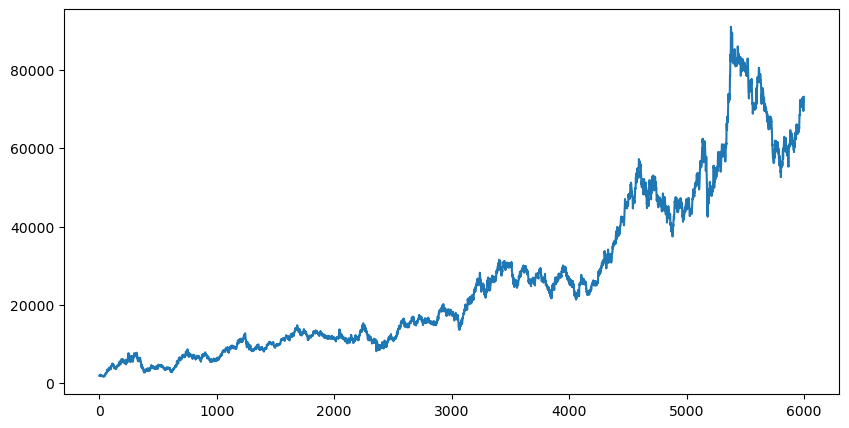

In [10]:
plt.figure(figsize=(10,5))
df.Close.plot()

`df`의 변화율을 시각화 합니다.

<Axes: >

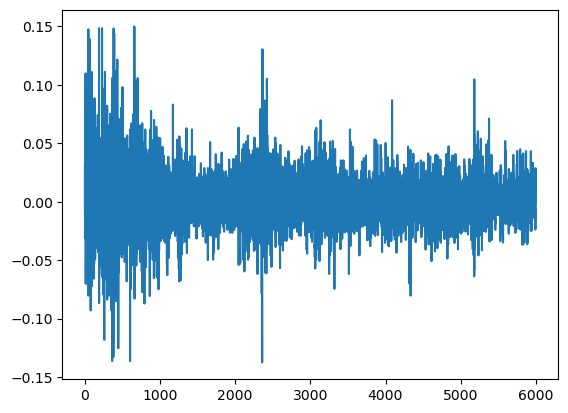

In [11]:
df.Change.plot()

### 1.3 데이터 전처리 및 분할

`df`의 `Open`, `High`, `Low`, `Close`, `Volume` 컬럼에 MinMaxScaler()를 적용합니다.

In [12]:
scaler = MinMaxScaler()
scale_cols = df.columns[1:-1]
scale_cols

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [13]:
df_scaled = scaler.fit_transform(df[scale_cols])
df[scale_cols] = pd.DataFrame(df_scaled)

In [14]:
df

,Date,Open,High,Low,Close,Volume,Change
0,1999-04-02,0.020797,0.020010,0.020827,0.002820,0.003019,NaN
1,1999-04-06,0.020797,0.019907,0.020726,0.002607,0.005631,-0.010117
2,1999-04-07,0.020576,0.020186,0.020592,0.003267,0.012852,0.031737
3,1999-04-08,0.021118,0.019990,0.020983,0.003088,0.005116,-0.008342
4,1999-04-09,0.021406,0.020010,0.020849,0.003435,0.005887,0.016299
...,...,...,...,...,...,...,...
5995,2023-07-10,0.775194,0.727273,0.773184,0.759438,0.129713,-0.005722
5996,2023-07-11,0.777409,0.738636,0.783240,0.781816,0.134846,0.028777
5997,2023-07-12,0.788483,0.743802,0.794413,0.786291,0.114893,0.005594
5998,2023-07-13,0.801772,0.750000,0.803352,0.786291,0.159649,0.000000


실제 예측에 사용할 데이터를 분할하여 `test_df`에 저장합니다.

In [15]:
window_size = 20
test_df = df.tail(window_size)
test_df

,Date,Open,High,Low,Close,Volume,Change
5980,2023-06-19,0.789590,0.740702,0.792179,0.778459,0.122925,-0.008357
5981,2023-06-20,0.782946,0.737603,0.786592,0.780697,0.127986,0.002809
5982,2023-06-21,0.782946,0.735537,0.786592,0.770627,0.117673,-0.012605
5983,2023-06-22,0.777409,0.738636,0.783240,0.779578,0.126359,0.011348
5984,2023-06-23,0.797342,0.745868,0.800000,0.782935,0.136530,0.004208
5985,2023-06-26,0.794020,0.748967,0.798883,0.791886,0.116735,0.011173
5986,2023-06-27,0.802879,0.750000,0.804469,0.794124,0.104566,0.002762
5987,2023-06-28,0.803987,0.751033,0.804469,0.795242,0.097259,0.001377
5988,2023-06-29,0.809524,0.758264,0.808939,0.791886,0.135428,-0.004127
5989,2023-06-30,0.802879,0.751033,0.801117,0.789648,0.129501,-0.002762


실제 예측에 사용할 데이터를 제외 한 데이터를 `df`에 저장합니다.


In [16]:
df = df.iloc[:-window_size]
df

,Date,Open,High,Low,Close,Volume,Change
0,1999-04-02,0.020797,0.020010,0.020827,0.002820,0.003019,NaN
1,1999-04-06,0.020797,0.019907,0.020726,0.002607,0.005631,-0.010117
2,1999-04-07,0.020576,0.020186,0.020592,0.003267,0.012852,0.031737
3,1999-04-08,0.021118,0.019990,0.020983,0.003088,0.005116,-0.008342
4,1999-04-09,0.021406,0.020010,0.020849,0.003435,0.005887,0.016299
...,...,...,...,...,...,...,...
5975,2023-06-12,0.798450,0.747934,0.791061,0.776221,0.133593,-0.013889
5976,2023-06-13,0.794020,0.745868,0.800000,0.787410,0.146472,0.014085
5977,2023-06-14,0.798450,0.745868,0.794413,0.786291,0.138873,-0.001389
5978,2023-06-15,0.798450,0.746901,0.796648,0.781816,0.150765,-0.005563


`df`를 RNN 계열 모델이 학습할 수 있는 데이터 형태로 변환하여 `X`, `y`에 저장합니다.

In [17]:
def sliding_window(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [18]:
train_cols = ["Open", "Change", "High", "Low", "Volume"]  # 5개
test_cols = ["Close"]

X, y = sliding_window(df[train_cols], df[test_cols], window_size)


`X`의 shape를 확인합니다.

In [19]:
X.shape  # 5개 범주를 행 20개씩 묶고 한 칸씩 미루면서 5960개의 데이터를 만들었다

(5960, 20, 5)

`X`의 가장 마지막에 담긴 값을 확인합니다.

In [20]:
pd.DataFrame(X[-1], columns=train_cols)  # 맨 마지막 5*20개, 그리고 찐 막 한 개는 target data로 쓸 거임

,Open,Change,High,Low,Volume
0,0.729790,-0.006116,0.680785,0.724022,0.118990
1,0.730897,0.018462,0.683884,0.734078,0.159809
2,0.750831,0.033233,0.706612,0.754190,0.225337
3,0.757475,0.001462,0.712810,0.759777,0.160236
4,0.758583,-0.001460,0.709711,0.760894,0.094807
5,0.754153,0.001462,0.709711,0.759777,0.090724
6,0.774086,0.004380,0.723140,0.767598,0.157588
7,0.772979,0.021802,0.727273,0.776536,0.216480
8,0.789590,0.028450,0.746901,0.795531,0.304264
9,0.801772,-0.012448,0.748967,0.793296,0.284212


데이터 길이 중 90%에 해당하는 수를 `train_szie`에 저장합니다.

In [21]:
# train으로 사용 할 size를 지정합니다.
train_size = int(len(X)*0.9)  # 5960개 중 90%는 훈련데이터

In [22]:
train_size

5364

`X`의 length 만큼의 np.arange를 `idx`에 저장 후 shuffle 합니다.

In [23]:
# ts_data의 lenth 만큼의 np.arange를 idx에 저장합니다.
idx = np.arange(len(X))

In [24]:
idx

array([   0,    1,    2, ..., 5957, 5958, 5959])

`idx`와 `train_size`를 이용하여 train, test로 쓰일 `idx`를 나누어 각각 `train_idx`, `test_idx`에 저장합니다.

In [25]:
train_idx = idx[:train_size]
test_idx = idx[train_size:]

`X`, `y`, `train_idx`, `test_idx`를 이용하여 `X_train`, `X_test`, `y_train`, `Y_test`를 만듭니다.

In [26]:
X_train = X[train_idx]
X_test = X[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

In [27]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5364, 20, 5)
(5364, 1)
(596, 20, 5)
(596, 1)


### 1.4 모델 구현

시계열 데이터를 학습 할 `model`을 구현합니다.

In [35]:
# Sequential을 이용하여 RNN 기반 모델을 구현합니다.
model = Sequential([
    layers.Bidirectional(layers.LSTM(64)),  # 64개짜리 뭐가? hidden state가?
    layers.Dense(1)  # 출력값을 숫자 하나값으로 나오도록 → 그 다음날의 종가가 되도록
])


`model`을 컴파일합니다.

In [36]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [32]:
X_train  # 맨 처음에 nan이 하나 떠서 엉망이되었다

array([[[ 0.02079734,         nan,  0.02001033,  0.02082682,
          0.00301905],
        [ 0.02079734, -0.01011715,  0.01990702,  0.02072626,
          0.0056315 ],
        [ 0.02057586,  0.03173749,  0.02018595,  0.02059218,
          0.01285172],
        ...,
        [ 0.02122924,  0.        ,  0.02018595,  0.02132961,
          0.00673675],
        [ 0.02122924, -0.05454545,  0.01980372,  0.02032402,
          0.0081894 ],
        [ 0.02012182, -0.01758242,  0.01877066,  0.01963128,
          0.01249871]],

       [[ 0.02079734, -0.01011715,  0.01990702,  0.02072626,
          0.0056315 ],
        [ 0.02057586,  0.03173749,  0.02018595,  0.02059218,
          0.01285172],
        [ 0.02111849, -0.00834202,  0.01998967,  0.02098324,
          0.00511613],
        ...,
        [ 0.02122924, -0.05454545,  0.01980372,  0.02032402,
          0.0081894 ],
        [ 0.02012182, -0.01758242,  0.01877066,  0.01963128,
          0.01249871],
        [ 0.01991141, -0.00167785,  0.01859504, 

### 1.5 모델 학습

`model`을 학습합니다.

In [30]:
hist = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=16)

Epoch 1/20
336/336 [==============================] - 8s 8ms/step - loss: nan
Epoch 2/20
336/336 [==============================] - 3s 8ms/step - loss: nan
Epoch 3/20
336/336 [==============================] - 3s 8ms/step - loss: nan
Epoch 4/20
336/336 [==============================] - 3s 8ms/step - loss: nan
Epoch 5/20
336/336 [==============================] - 3s 8ms/step - loss: nan
Epoch 6/20
336/336 [==============================] - 3s 8ms/step - loss: nan
Epoch 7/20
336/336 [==============================] - 3s 8ms/step - loss: nan
Epoch 8/20
336/336 [==============================] - 3s 8ms/step - loss: nan
Epoch 9/20
336/336 [==============================] - 3s 8ms/step - loss: nan
Epoch 10/20
336/336 [==============================] - 3s 8ms/step - loss: nan
Epoch 11/20
336/336 [==============================] - 3s 8ms/step - loss: nan
Epoch 12/20
336/336 [==============================] - 3s 8ms/step - loss: nan
Epoch 13/20
336/336 [==============================] - 3s 8ms

## 1.6 모델 테스트

`y_test`의 값과 모델이 예측한 값을 시각화합니다.

19/19 [==============================] - 1s 5ms/step


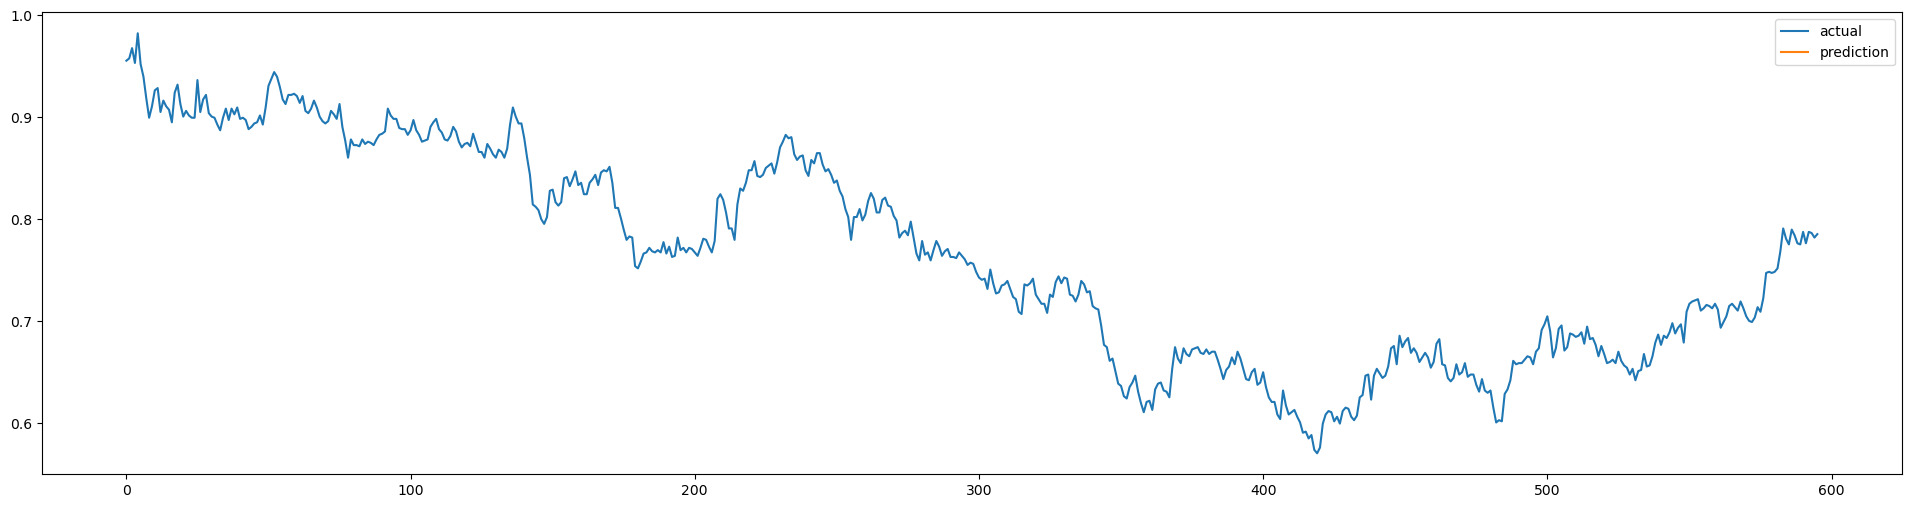

In [31]:
plt.figure(figsize=(24, 6))
plt.plot(y_test, label='actual')
plt.plot(model.predict(X_test), label='prediction')
plt.legend()
plt.show()  # 학습이 잘 안되었다. 맨 처음에 nan이 있어서. nan 빼주고 학습하자

In [37]:
hist = model.fit(X_train[1:], y_train[1:],   # 다시 할 땐 리스타트하고 처음부터 다시 학습해야한다
                    epochs=20, 
                    batch_size=16)

Epoch 1/20
336/336 [==============================] - 9s 10ms/step - loss: 0.0012
Epoch 2/20
336/336 [==============================] - 3s 10ms/step - loss: 1.6604e-04
Epoch 3/20
336/336 [==============================] - 4s 10ms/step - loss: 1.3187e-04
Epoch 4/20
336/336 [==============================] - 3s 10ms/step - loss: 1.2851e-04
Epoch 5/20
336/336 [==============================] - 3s 10ms/step - loss: 1.2929e-04
Epoch 6/20
336/336 [==============================] - 3s 10ms/step - loss: 1.1080e-04
Epoch 7/20
336/336 [==============================] - 3s 10ms/step - loss: 1.2753e-04
Epoch 8/20
336/336 [==============================] - 3s 10ms/step - loss: 1.1876e-04
Epoch 9/20
336/336 [==============================] - 3s 10ms/step - loss: 9.8854e-05
Epoch 10/20
336/336 [==============================] - 3s 10ms/step - loss: 1.0706e-04
Epoch 11/20
336/336 [==============================] - 3s 10ms/step - loss: 9.6037e-05
Epoch 12/20
336/336 [==============================] - 3

19/19 [==============================] - 1s 7ms/step


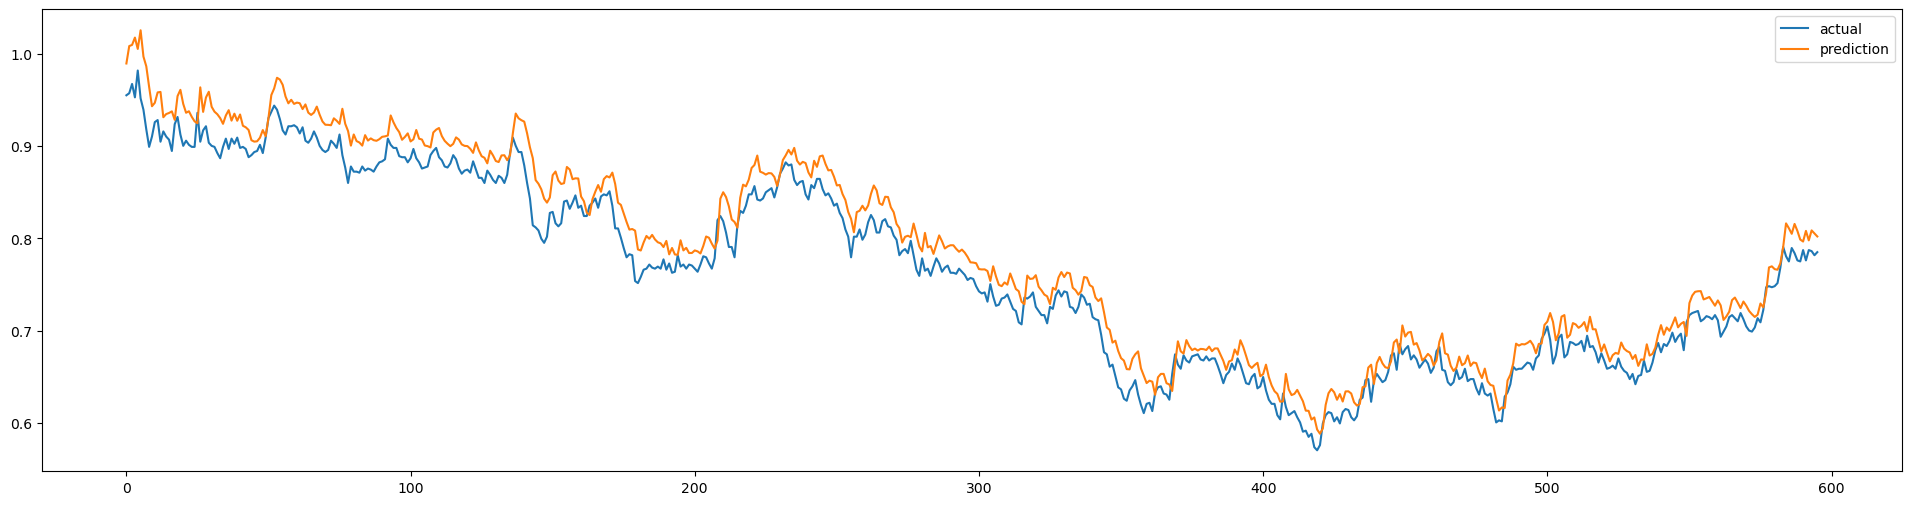

In [38]:
plt.figure(figsize=(24, 6))
plt.plot(y_test, label='actual')
plt.plot(model.predict(X_test), label='prediction')
plt.legend()
plt.show()  # 이번에는 제대로 예측한걸 볼 수 있다!

최근 20일간의 데이터를 이용하여 현재일 대비 다음날의 종가 변화율을 예측합니다.



In [39]:
pred_value = model.predict(test_df[train_cols].values.reshape(1, window_size, len(train_cols)))

change_value = (test_df.Close.iloc[-1] / pred_value)[0][0]
if change_value > 0:
    print(f"다음 종가는 {abs(change_value):.4f}% 상승")
elif change_value < 0:
    print(f"다음 종가는 {abs(change_value):.4f}% 하락")
else:
    print("다음 종가는 변화 없음")


1/1 [==============================] - 0s 24ms/step
다음 종가는 0.9759% 상승


In [40]:
# 한 단계씩 늦게 따라가고 있다 → 못맞췄네? 다시 올리고, 다시 내리고 조금 후행해서 따라간다. 결국 예측이 어렵다

그래프를 보면 예측 성능이 매우 좋아 보입니다. 과연 우리는 AI를 배우면 주식부자가 될 수 있을까요.